In [111]:
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')

In [30]:
import pandas as pd
train = pd.read_csv("../data/titanic/train.csv")

example = train[['Pclass', 'Sex', 'Age', 'Cabin']]
example.head()

,Pclass,Sex,Age,Cabin
0,3,male,22.0,NaN
1,1,female,38.0,C85
2,3,female,26.0,NaN
3,1,female,35.0,C123
4,3,male,35.0,NaN


### continuous variables
 - are always approximations, e.g. the age could be 22 years, 2 months, 1 week, 1 day, 10 hours, 2 minuts, 55 seconds, ...
 - have an ordering, e.g. $22\,\text{years} < 38\,\text{years}$
 - you can interpret differences: $38\,\text{years} - 22\,\text{years} = 16\,\text{years}$

In [31]:
example[['Age']].head()

,Age
0,22.0
1,38.0
2,26.0
3,35.0
4,35.0


### categorical or discrete variables
  - are always finite, e.g. Sex is most of the time binary and it's either female or male (I know that's not the best exambple - please do not confuse sex with gender)
  - there is no ordering
  - you can not interpret differences
  - sex is a special case because it's also a __binary variable__; another example for discrete variables is marital status that can be __single, married, widowed, divorced, separated__

In [32]:
example[['Sex']].head()

,Sex
0,male
1,female
2,female
3,female
4,male


### ordinal variables
  - are always finite, e.g the passenger-class is either 1, 2, or 3 but nothing in between
  - it's still possible to have an ordering: $\text{p-class 1} > \text{p-class 2} > \text{p-class 3}$
  - you can not interpret the differences: $\text{p-class 3} - \text{p-class 2} = \text{p-class 
 1}$?

In [33]:
example[['Pclass']].head()

,Pclass
0,3
1,1
2,3
3,1
4,3


## Processing of Variable
### Continuous Variables

We can easily transform a continuous variable into a ordinal variable by setting cut-points. E.g., we could say that all passengers younger than 2 years are renamed as 'Baby', all passengers between 2 years and 17 years as 'Child', etc..

In [34]:
example['Age_binned'] =pd.cut(example.Age,bins=[0,2,17,65,99],labels=['Baby','Child','Adult','Elderly'])# .iloc[30:40]
example[['Age','Age_binned']][30:40]

,Age,Age_binned
30,40.0,Adult
31,NaN,NaN
32,NaN,NaN
33,66.0,Elderly
34,28.0,Adult
35,42.0,Adult
36,NaN,NaN
37,21.0,Adult
38,18.0,Adult
39,14.0,Child


### Categorical or discrete variables
For mathematical models it's hard to work with categories as for example *male*, *female* or *Adult*, *Baby*, *Child*, etc..<br>
This is why we have to turn them into categorical variables. This is done by adding new columns to the data, one for each category-level:

In [35]:
nexample = pd.concat([example, pd.get_dummies(example['Age_binned'])], axis=1)
nexample[['Age','Age_binned','Baby', 'Child', 'Adult', 'Elderly']][30:40]

,Age,Age_binned,Baby,Child,Adult,Elderly
30,40.0,Adult,0,0,1,0
31,NaN,NaN,0,0,0,0
32,NaN,NaN,0,0,0,0
33,66.0,Elderly,0,0,0,1
34,28.0,Adult,0,0,1,0
35,42.0,Adult,0,0,1,0
36,NaN,NaN,0,0,0,0
37,21.0,Adult,0,0,1,0
38,18.0,Adult,0,0,1,0
39,14.0,Child,0,1,0,0


This is called:<br>
  - one-hot encoding
  - sometimes this is also incorrectly called dummy encoding
  - real __dummy encoding__ has one column less than one-hot encoding: The idea is, if its not *Child*, nor *Adult* or *Elderly*, then is must be *Baby* - so we do not need an extra column for *Baby*
  
Most intuitively the __real__ dummy-encoding can be seen with __sex__: even though there are two different categories, we just need one column

In [43]:
nnexample = pd.concat([nexample, nexample[['Sex']].replace({"Sex": {'female':1, 'male': 0}}).rename(columns={'Sex': 'Sex2'})], axis=1)
nnexample[['Sex', 'Sex2']].head()

,Sex,Sex2
0,male,0
1,female,1
2,female,1
3,female,1
4,male,0


### ordinal data
  - there are methods for ordinal data, e.g. ordinal regression
  - most of the time ordinal variables are just treated as categorical variables

## Missing Data
Data can be missing:
  - at random
  - systematically, i.e. the fact that the data is missing could bear some valuable information
  
For categorical and ordinal data, missing data is just another category.<br>
For continuous variables there are several possibilities to deal with missing data. The most frequent ones are:<br>
  - imputation by the mean (the mean-value of all non-missing values is taken)
  - imputation by the median (the value with half of all values larger and half of all values smaller is taken)
  - imputation by the mode (the most frequent value is taken)
  
However, since we do not know for sure, why data is missing it is often helpfull to keep track of it by creating a new indicator variable for missing values:

__First, we create the indicator variable:__

In [47]:
nnexample['missing_Age'] = pd.isna(nexample['Age']).astype(int)
nnexample[['Age', 'missing_Age']][30:40]

,Age,missing_Age
30,40.0,0
31,NaN,1
32,NaN,1
33,66.0,0
34,28.0,0
35,42.0,0
36,NaN,1
37,21.0,0
38,18.0,0
39,14.0,0


__Second, we impute missing values with the average Age:__

In [49]:
nnexample['Age'] = nnexample['Age'].fillna(nnexample['Age'].mean())
nnexample[['Age', 'missing_Age']][30:40]

,Age,missing_Age
30,40.000000,0
31,29.699118,1
32,29.699118,1
33,66.000000,0
34,28.000000,0
35,42.000000,0
36,29.699118,1
37,21.000000,0
38,18.000000,0
39,14.000000,0


### Interactions
Interactions are another important concept in linear modelling. Here, the effect of one variable on the dependent variable $y$ depends on the value of another variable.<br>
In the example below we try to model the probability that a person buys a house. Of course, monthly income is an important variable and the higher it is, the more likely that said person will buy a house. Another important variable is marital status. Married people with children in the household tend strongly to buy houses, especially if their monthly income is high. On the other hand, singles, even if they have a high income, will tend not to buy a house.<br>
So we see, the variable "monthly income" __interacts__ with the variable "marital status": the effect of the two variables together is more than the sum of the effects of the individual variables.

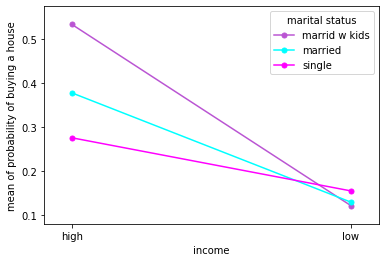

In [50]:
import numpy as np
from statsmodels.graphics.factorplots import interaction_plot
import pandas as pd

income = np.random.randint(0, 2, size = 80) # low vs high
marital = np.random.randint(1, 4, size = 80) # single, married, married & kids

probability = np.random.rand(80) + income * np.random.rand(80) * marital
probability = (probability - np.min(probability))
probability = probability/np.max(probability)

marital = pd.Series(marital)
marital.replace(to_replace = {1:'single', 2:'married', 3:'marrid w kids'}, inplace =True)

income = pd.Series(income)
income.replace(to_replace = {0:'low', 1:'high'}, inplace = True)

fig = interaction_plot(income, marital, probability,
                       colors=['mediumorchid', 'cyan', 'fuchsia'], ms=10, xlabel='income',
                       ylabel='probability of buying a house',
                       legendtitle='marital status')


### Standardization / Normalization
Sometimes we have to bring different variables into the same range. This is very important for Neural Networks, but also for other algorithms it can sometimes be benefitial. <br>
Assume, we have the age of some passengers as in the following table:

In [104]:
from IPython.display import display, display_html

passenger_age = train[['Name', 'Age']].dropna()[0:15]
mean_std = pd.DataFrame({'mean':[passenger_age['Age'].mean()], 'standarddeviation':[passenger_age['Age'].std()]})

df1_styler = passenger_age.style.set_table_attributes("style='display:inline'")\
.set_caption('passengers and age')
df2_styler = mean_std.style.set_table_attributes("style='display:inline'").set_caption('mean value and standarddeviation')

display_html(df1_styler._repr_html_() + ' ' + df2_styler._repr_html_(), raw=True)

,Name,Age
0,"Braund, Mr. Owen Harris",22.000000
1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",38.000000
2,"Heikkinen, Miss. Laina",26.000000
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.000000
4,"Allen, Mr. William Henry",35.000000
6,"McCarthy, Mr. Timothy J",54.000000
7,"Palsson, Master. Gosta Leonard",2.000000
8,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",27.000000
9,"Nasser, Mrs. Nicholas (Adele Achem)",14.000000
10,"Sandstrom, Miss. Marguerite Rut",4.000000


We obtain normalized values by applying the following z-transform:

\begin{eqnarray}
z_i=&\frac{x_i - \bar{x}}{\sigma}\\
\text{with:}&\\
\bar{x}=&\text{mean}\\
\sigma=&\text{standarddeviation}
\end{eqnarray}



In [105]:
passenger_age['normalized age'] = (passenger_age['Age'] - passenger_age['Age'].mean())/passenger_age['Age'].std()
display(passenger_age)

,Name,Age,normalized age
0,"Braund, Mr. Owen Harris",22.0,-0.427976
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,0.481000
2,"Heikkinen, Miss. Laina",26.0,-0.200732
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,0.310567
4,"Allen, Mr. William Henry",35.0,0.310567
6,"McCarthy, Mr. Timothy J",54.0,1.389976
7,"Palsson, Master. Gosta Leonard",2.0,-1.564197
8,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",27.0,-0.143921
9,"Nasser, Mrs. Nicholas (Adele Achem)",14.0,-0.882465
10,"Sandstrom, Miss. Marguerite Rut",4.0,-1.450575


Now, let's do the same for another variable: Fare - the price payed for the passage

In [106]:
passenger_age = passenger_age.merge(train['Fare'] * 10, left_index=True, right_index=True)
passenger_age['normalized_Fare'] = (passenger_age['Fare'] - passenger_age['Fare'].mean())/passenger_age['Fare'].std()
display(passenger_age)

,Name,Age,normalized age,Fare,normalized_Fare
0,"Braund, Mr. Owen Harris",22.0,-0.427976,72.500,-0.868610
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,0.481000,712.833,2.347294
2,"Heikkinen, Miss. Laina",26.0,-0.200732,79.250,-0.834709
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,0.310567,531.000,1.434086
4,"Allen, Mr. William Henry",35.0,0.310567,80.500,-0.828432
6,"McCarthy, Mr. Timothy J",54.0,1.389976,518.625,1.371936
7,"Palsson, Master. Gosta Leonard",2.0,-1.564197,210.750,-0.174285
8,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",27.0,-0.143921,111.333,-0.673581
9,"Nasser, Mrs. Nicholas (Adele Achem)",14.0,-0.882465,300.708,0.277505
10,"Sandstrom, Miss. Marguerite Rut",4.0,-1.450575,167.000,-0.394008


The un-standardized variables accross passengers look like this:

<AxesSubplot:>

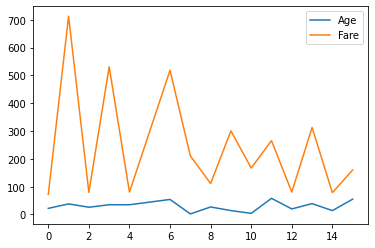

In [107]:
passenger_age[['Age', 'Fare']].plot.line()

The standardized variables accross passengers look like this:

<AxesSubplot:>

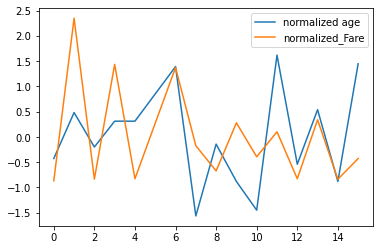

In [108]:
passenger_age[['normalized age', 'normalized_Fare']].plot.line()

## not covered here
The following topics are more advanced and do not apply to tree-methods. In a possible follow-up we can discuss them as well:
  - power-transforms
  - mean-encoding

# Overfitting and Cross-Validation
All classification and regression algorithms are prone to overfitting:<br>
The algorithms learn pecularities of the train-data, that are not present in the real-world data.<br> 
When over-fitted, the algorithms are not generalizing to the real data.<br>

__Capacity__ refers to the ratio of free parameters and the amount of training data.

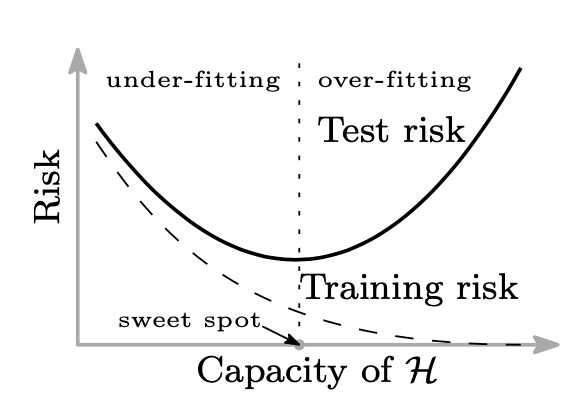

In [112]:
Image('../images/bias_variance_tradeoff.png')

# Cross-Validation
In most real-word applications we do not know the data universe, i.e. we do not know all possible data points that might be there. Our training data is possibly just a biased subsample of the population.<br>
When we fit our algorithm to such a subsample its performance will degrade, when applied to new, unseen data points. In order to have an idea, how well our algorithm will perform in such cases, we can use a cross-validation scheme:<br>
In the example below, a 5-fold cross-validation is illustrated.
* split the training data in 5 equal sized parts. In *sklearn* you can choose *StratifiedKFold*, that essentially tries to keep the percentages of all classes stable within each fold.
* train your algorithmm on 4 folds and classify data in the 5th hold-out fold. Keep the performance on this fold.
* repeat the last step 4 more times and use each time another fold as your hold-out fold.
* at the end, you have 5 independent estimates of your algorithm's performance
* compute the mean of theses 5 estimates for an overall estimate

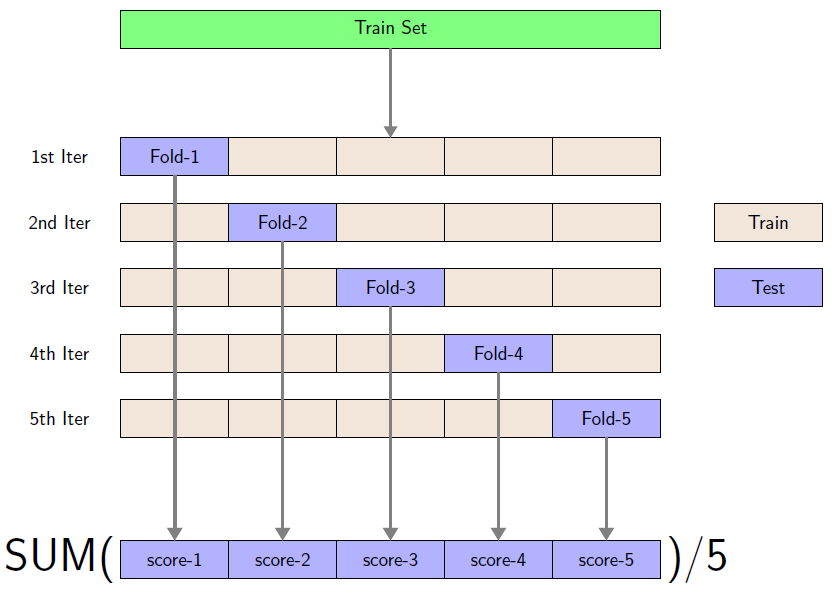

In [113]:
from IPython import display
display.Image('../images/cross_validation.png')